In [41]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline
%config InlineBackend.figure_format = 'svg' 

import torch
import numpy as np

import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torch.nn import Parameter

from torch.distributions import Poisson
from torch.distributions import Geometric
from torch.distributions import uniform
from torch.distributions import constraints
from torch.distributions import normal
from torch.distributions import cauchy

import cmath as cm

from torch.distributions.utils import logits_to_probs

In [2]:
np.random.seed(228)
torch.manual_seed(228)
torch.cuda.manual_seed(228)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
def fix(num, pl=5, d=3):
    return ("%" + str(pl)+"." + str(d) + "e") % num


# New Functions

## /==================================================\

## Base Uniform

In [38]:
class UnifNoise(autograd.Function):
    
    @staticmethod
    def forward(ctx, l):
        n = Poisson(l).sample()
        r = uniform.Uniform(torch.tensor([-0.5]), torch.tensor([0.5])).sample()
        ctx.save_for_backward(n, r, l)
        z = n + r
        return z
    
    @staticmethod
    def backward(ctx, grad_output):
        n, r, l, = ctx.saved_tensors
        dzdl = (0.5 + r) + (0.5 - r) * n / l
        return dzdl * grad_output
    
    

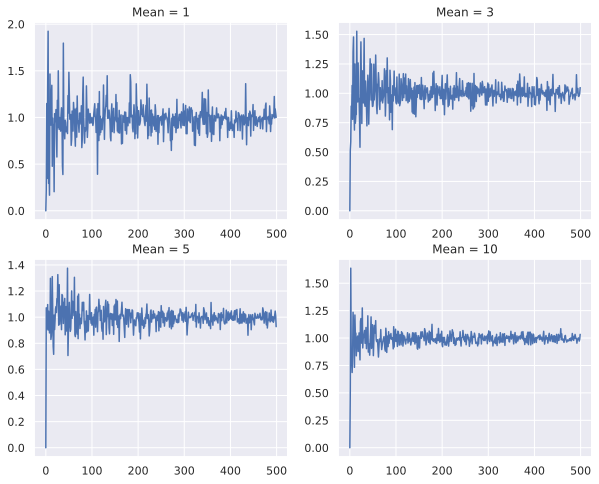

In [69]:
f = UnifNoise.apply
mean_param = np.array([1, 3, 5, 10])
s = 500
fig = plt.figure(figsize=(10, 8))
titles = ['Mean = 1', 'Mean = 3', 'Mean = 5', 'Mean = 10']
ax = []

for h in range(mean_param.shape[0]):
    
    main_grad = np.zeros(shape=(s))
    grad_list = np.zeros(shape=(s))
    for j in range(mean_param[h]):
        for i in range(1, s):
            b = torch.tensor((float)(i / 10), requires_grad=True)
            t = f(b)
            res = t
            res.backward()
            grad_list[i] = b.grad
        main_grad += grad_list
    
    main_grad /= mean_param[h]
    ax.append(fig.add_subplot(221 + h))
    ax[h].plot(main_grad)
    ax[h].grid('on')
    ax[h].set_title(titles[h])

plt.show()

## Uniform with different domain

In [85]:
class ModifUnifNoise(autograd.Function):
    
    @staticmethod
    def forward(ctx, l):
        n = Poisson(l).sample()
        r = uniform.Uniform(torch.tensor([-0.25]), torch.tensor([0.25])).sample()
        ctx.save_for_backward(n, r, l)
        z = n + r
        return z
    
    @staticmethod
    def backward(ctx, grad_output):
        n, r, l, = ctx.saved_tensors
        dzdl = 0.5 * ((0.5 + 2. * r) - (0.5 - 2. * r) * n / l)
        return dzdl * grad_output
    
    

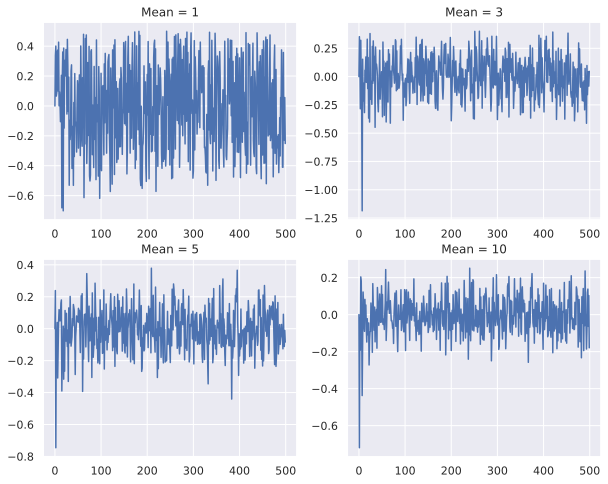

In [86]:
f = ModifUnifNoise.apply

mean_param = np.array([1, 3, 5, 10])
s = 500
fig = plt.figure(figsize=(10, 8))
titles = ['Mean = 1', 'Mean = 3', 'Mean = 5', 'Mean = 10']
ax = []

for h in range(mean_param.shape[0]):
    
    main_grad = np.zeros(shape=(s))
    grad_list = np.zeros(shape=(s))
    for j in range(mean_param[h]):
        for i in range(1, s):
            b = torch.tensor((float)(i / 10), requires_grad=True)
            t = f(b)
            res = t
            res.backward()
            grad_list[i] = b.grad
        main_grad += grad_list
    
    main_grad /= mean_param[h]
    ax.append(fig.add_subplot(221 + h))
    ax[h].plot(main_grad)
    ax[h].grid('on')
    ax[h].set_title(titles[h])

plt.show()

In [1]:
"""
class CauchyNoise(autograd.Function):
    
    @staticmethod
    def forward(ctx, l):
        n = Poisson(l).sample()
        r = 1.
        while (not(r >= -0.5 and r <= 0.5)):
            r = cauchy.Cauchy(loc=0., scale=torch.tensor(cm.pi)).sample()
        ctx.save_for_backward(n, r, l)
        z = n + r
        return z
    
    @staticmethod
    def backward(ctx, grad_output):
        n, r, l, = ctx.saved_tensors
        k = 1. + (cm.pi * l)**2
        t = cm.atan(cm.pi * l) / cm.pi
        dzdl = k * (t * (1. + n/l) + (1. - n/l) / 2.)
        return dzdl * grad_output
    
"""

'\nclass CauchyNoise(autograd.Function):\n    \n    @staticmethod\n    def forward(ctx, l):\n        n = Poisson(l).sample()\n        r = 1.\n        while (not(r >= -0.5 and r <= 0.5)):\n            r = cauchy.Cauchy(loc=0., scale=torch.tensor(cm.pi)).sample()\n        ctx.save_for_backward(n, r, l)\n        z = n + r\n        return z\n    \n    @staticmethod\n    def backward(ctx, grad_output):\n        n, r, l, = ctx.saved_tensors\n        k = 1. + (cm.pi * l)**2\n        t = cm.atan(cm.pi * l) / cm.pi\n        dzdl = k * (t * (1. + n/l) + (1. - n/l) / 2.)\n        return dzdl * grad_output\n    \n'

In [2]:
"""
f = CauchyNoise.apply
grad_list = []

for i in range(1, 50):
    b = torch.tensor((float)(i / 10), requires_grad=True)
    t = f(b)
    res = t
    res.backward()
    grad_list.append(b.grad)
    

plt.plot(grad_list)
plt.show()
"""

'\nf = CauchyNoise.apply\ngrad_list = []\n\nfor i in range(1, 50):\n    b = torch.tensor((float)(i / 10), requires_grad=True)\n    t = f(b)\n    res = t\n    res.backward()\n    grad_list.append(b.grad)\n    \n\nplt.plot(grad_list)\nplt.show()\n'

## \\==================================================/

# Simple Task

## /==================================================\

In [99]:
class ST(nn.Module):
    
    def __init__(self, init_param=15., lambda0=6.):
        super(ST, self).__init__()
        self.lambda0 = torch.tensor(lambda0)
        self.rate = Parameter(torch.tensor(init_param))
        self.SmartSample = UnifNoise.apply
        pass
        
        
    def forward(self):
        self.z = 0.
        mean_param = 5
        for i in range(mean_param):
            self.z += self.SmartSample(self.rate)
        self.z /= mean_param    
        out = self.z - self.lambda0
        return out

In [100]:
class STLoss(nn.Module):
    
    def __init__(self):
        super(STLoss, self).__init__()
        pass
    
    def forward(self, out):
        loss = out * out
        return loss
    

In [103]:
def train(model, criterion, optimizer):
    
    try:
        for epoch in range(500):
            loss = criterion(model.forward())
            loss.backward()
            if (epoch % 50 == 0):
                print("grad rate = ", fix(model.rate.grad.item()), end="   ")
            optimizer.step()
            optimizer.zero_grad()
            if (epoch % 50 == 0):
                print("rate: ", fix(model.rate.item()))
        
    except KeyboardInterrupt:
        pass
    
    

In [105]:
model = ST()
criterion = STLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-1)
model = train(model, criterion, optimizer)

grad rate =  7.475e+00   rate:  1.490e+01
grad rate =  1.107e+01   rate:  1.057e+01
grad rate =  7.183e-02   rate:  7.723e+00
grad rate =  1.182e+00   rate:  6.486e+00
grad rate =  -3.137e+00   rate:  5.732e+00
grad rate =  -1.552e+00   rate:  5.762e+00
grad rate =  7.811e-01   rate:  5.784e+00
grad rate =  -3.082e+00   rate:  5.623e+00
grad rate =  5.392e-01   rate:  6.287e+00
grad rate =  -1.912e+00   rate:  5.935e+00


## \\==================================================/

# Test computing gradient dW/dz

## /==================================================\

In [117]:
#torch
init_param = 1.
U = init_param * torch.randn(40, 100, requires_grad=True)
V = init_param * torch.randn(100, 20, requires_grad=True)
z = torch.tensor(90.9, requires_grad=True)

u, v = U[:, :(int)(z) + 1], V[:(int)(z) + 1]
mask = torch.eye((int)(z) + 1, (int)(z) + 1)
mask[(int)(z), (int)(z)] *= (z - (int)(z)).sqrt()
    
mx = torch.matmul(torch.matmul(u, mask), torch.matmul(mask, v))
res = torch.norm(mx) ** 2

res.backward()
z.grad

tensor(396.2234)

In [118]:
#analatical decision
true_grad = 2 * torch.matmul(u[:, (int)(z)].T, torch.matmul(u, mask))
true_grad = torch.matmul(true_grad, torch.matmul(mask, v))
true_grad = torch.matmul(true_grad, v[(int)(z)].T)
true_grad

tensor(396.2234, grad_fn=<DotBackward>)

### alternative realization

##  \\===================================================/